**Copyright 2018 The TF-Agents Authors.**

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/tf_agents/colabs/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/7_SAC_minitaur_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [0]:
# Note: If you haven't installed the following dependencies, run:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
!pip install tf-agents-nightly
!pip install tf-nightly

## Introduction

This example shows how to train a [Soft Actor Critic](https://arxiv.org/abs/1801.01290)  agent on the [Minitaur](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/minitaur.py) environment using the TF-Agents library.

If you've worked through the [DQN Colab](https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/1_dqn_tutorial.ipynb) this should feel very familiar. Notable changes include:

  * Changing the agent from DQN to SAC.
  * Training on Minitaur which is a much more complex environment than CartPole. The Minitaur environment aims to train a quadruped robot to move forward.
  * We do not use a random policy to perform an initial data collection.


## Setup

First we will import the different tools that we need and make sure we enable TF-V2 behavior as it is easier to iterate in Eager mode throughout the colab.

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import normal_projection_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


## Hyperparameters

In [24]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 1000000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (100,)
critic_joint_fc_layer_params = (100,)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 30 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

## Environment

Environments in RL represent the task or problem that we are trying to solve. Standard environments can be easily created in TF-Agents using `suites`. We have different `suites` for loading environments from sources such as the OpenAI Gym, Atari, DM Control, etc., given a string environment name.

Now let's load the Minituar environment from the Pybullet suite.

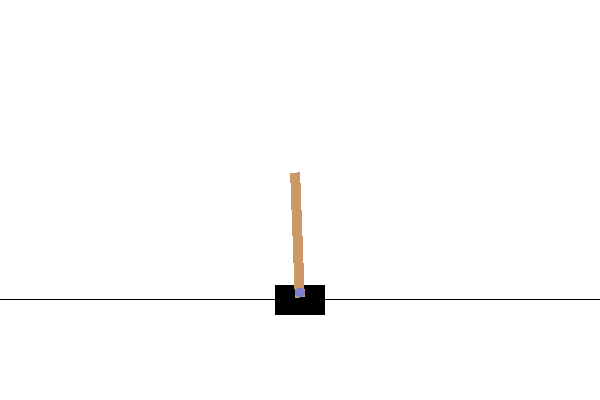

In [25]:
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In this environment the goal is for the agent to train a policy that will control the Minitaur robot and have it move forward as fast as possible. Episodes last 1000 steps and the return will be the sum of rewards throughout the episode. 

Let's look at the information the environment provides as an `observation` which the policy will use to generate `actions`.

In [26]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


As we can see the observation is fairly complex. We recieve 28 values representing the angles, velocities and torques for all the motors. In return the environment expects 8 values for the actions between `[-1, 1]`. These are the desired motor angles.


Usually we create two environments: one for training and one for evaluation. Most environments are written in pure python, but they can be easily converted to TensorFlow using the `TFPyEnvironment` wrapper. The original environment's API uses numpy arrays, the `TFPyEnvironment` converts these to/from `Tensors` for you to more easily interact with TensorFlow policies and agents.


In [27]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

To create an SAC Agent, we first need to create the networks that it will train. SAC is an actor-critic agent and so we will need two networks.

The critic will give us value estimates for `Q(s,a)`. That is, it will recieve as input an observation and an action, and it will give us an estimate of how good that action was for the given state.


In [28]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)

We will use this critic to train an `actor` network which will allow us to generate actions given an observation.

The `ActorNetwork` will predict parameters for a Normal distribution. This distribution will then be sampled, conditioned on the current observation,
, whenever we need to generate actions.

In [29]:
def normal_projection_net(action_spec,init_means_output_factor=0.1):
  return normal_projection_network.NormalProjectionNetwork(
      action_spec,
      mean_transform=None,
      state_dependent_std=True,
      init_means_output_factor=init_means_output_factor,
      std_transform=sac_agent.std_clip_transform,
      scale_distribution=True)


actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=actor_fc_layer_params,
    continuous_projection_net=normal_projection_net)

With these networks at hand we can now instantiate the agent.





In [30]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    train_step_counter=global_step)
tf_agent.initialize()

## Policies

In TF-Agents, policies represent the standard notion of policies in RL: given a `time_step` produce an action or a distribution over actions. The main method is `policy_step = policy.step(time_step)` where `policy_step` is a named tuple `PolicyStep(action, state, info)`.  The `policy_step.action` is the `action` to be applied to the environment, `state` represents the state for stateful (RNN) policies and `info` may contain auxiliary information such as log probabilities of the actions.

Agents contain two policies: the main policy (agent.policy) and the behavioral policy that is used for data collection (agent.collect_policy). For evaluation/deployment, we take the mean action by wrapping the main policy with GreedyPolicy().

In [31]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
collect_policy = tf_agent.collect_policy

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [32]:
def compute_avg_return(environment, policy, num_episodes=5):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


compute_avg_return(eval_env, eval_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

13.0

## Replay Buffer

In order to keep track of the data collected from the environment, we will use the TFUniformReplayBuffer. This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `tf_agent.collect_data_spec`.

In [33]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

For most agents, the `collect_data_spec` is a `Trajectory` named tuple containing the observation, action, reward etc.

## Data Collection

Now we will create a driver to collect experience to seed the replay buffer with. Drivers provide us with a simple way to collecter `n` steps or episodes on an environment using a specific policy.

In [34]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run()

(TimeStep(step_type=<tf.Tensor: id=2986453, shape=(1,), dtype=int32, numpy=array([1])>, reward=<tf.Tensor: id=2986454, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, discount=<tf.Tensor: id=2986455, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: id=2986456, shape=(1, 4), dtype=float32, numpy=
 array([[-0.00487277,  0.71068615,  0.20721416, -0.22529203]],
       dtype=float32)>), ())

In order to sample data from the replay buffer, we will create a `tf.data` pipeline which we can feed to the agent for training later. We can specify the `sample_batch_size` to configure the number of items sampled from the replay buffer. We can also optimize the data pipeline using parallel calls and prefetching.

In order to save space, we only store the current observation in each row of the replay buffer. But since the SAC Agent needs both the current and next observation to compute the loss, we always sample two adjacent rows for each item in the batch by setting `num_steps=2`.

In [35]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [36]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

In [37]:

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = 2.331745147705078
step = 10000: loss = -5.935619354248047
step = 10000: Average Return = 49.33333206176758
step = 15000: loss = -9.967754364013672
step = 20000: loss = -13.228894233703613
step = 20000: Average Return = 9.366666793823242
step = 25000: loss = -12.972071647644043
step = 30000: loss = -16.78702163696289
step = 30000: Average Return = 9.600000381469727
step = 35000: loss = -18.87862777709961
step = 40000: loss = -21.818866729736328
step = 40000: Average Return = 9.233333587646484
step = 45000: loss = -24.02640151977539
step = 50000: loss = -26.16067123413086
step = 50000: Average Return = 9.300000190734863
step = 55000: loss = -27.166919708251953
step = 60000: loss = -34.73271560668945
step = 60000: Average Return = 9.199999809265137
step = 65000: loss = -36.964290618896484
step = 70000: loss = -39.134273529052734
step = 70000: Average Return = 9.366666793823242
step = 75000: loss = -30.51305389404297
step = 80000: loss = -33.91838455200195
step = 80000:

KeyboardInterrupt: 

## Visualization



### Plots

We can plot average return vs global steps to see the performance of our agent. In `Minitaur`, the reward function is based on how far the minitaur walks in 1000 steps and penalizes the energy expenditure.

In [0]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

### Videos

It is helpful to visualize the performance of an agent by rendering the environment at each step. Before we do that, let us first create a function to embed videos in this colab.

In [0]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

The following code visualizes the agent's policy for a few episodes:

In [0]:
num_episodes = 3
video_filename = 'sac_minitaur.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)